***
***

# Assignment 2 - Extend My Playlist - 50 points

- This assignment will see you use a dataset of Spotify playlists, and build a GNN to build a playlist-track RecSys (Recommendation System). We'll use a type of layer called LightGCN for this task.
- You will almost certainly need a GPU for this assignment. The free tier GPUs of colab should suffice. So write your code with that in mind. While I was able to train it pretty well even on a non-GPU system, do note that it might take a lot longer, and the analysis part would require you to run the model multiple times
- The dataset you have been shared is a small part of a much larger dataset so the free tier colab GPU can handle it. Do **NOT** share the dataset with other people. We'll release details about the dataset after the assignment is over if you would like access to the full dataset.


## Marking Breakup
1. Code (40 points)
2. Model Results on Hidden Test set (10 points)
3. You will receive a bonus 10 points for being able to provide a visualisation of the embeddings your model learned. Hints for this are at the end of the assignment.
4. You will receive a bonus 5 points for well-documented code. So use your comments well, and remember to follow PEP guidelines.


### Details
- You may attempt this assignment **alone, or in teams of 2 or 3**. This assignment is heavier, yes, but should still be doable alone. The deadline is EOD 24/06/23.
- We have given a weak boilerplate code for you  with instructions. Following the instructions will be the easiest way to get the most grades. 
- This time, plagiarism across groups will mean that the assignment submission becomes null and void. No marks will be given to either group.
- We are not testing your literature review skils here. The dataset, modules to use, layers you'll need are all given below. Don't waste time hunting for better ones, the combination we have picked out is already very powerful.
- *30 points* are for the straight code work on your model (Section 1 and 2). The last 10 points are for the codework in training visualisation (Section 3).
- *10 points* are for the results of your model on a hidden test that is not being shared with you. You do not need to adjust your code in anyway, we will simply change the test set you have in your code to a test set we have.
- There's *10 points* for the visualisation of the training and analysis with different hyperparameters. This is weighted lesser than the main code work, but is far easier to implement. However, no marks will be given for this section if your model doesn't actually train at all.
- There's a *bonus 10 points* for embedding visualisation. This involves plotting the learnings of your model over epoch using UMAP Dimensionality Reduction and the Animation Submodule of Matplotlib. We stop here, but if you manage to get this done, you could go one step further to actually see what happens to datapoints in your model. Details of this section are given in the section itself.
- You get *bonus 5 points* if I find your codework to be very neat and well-documented. Naturally you need to atleast finish sections 1-3 to be eligible for these bonus points. Wouldn't be very helpful if you just emptied the notebook, printed 'Hello World!' with exquisite documentation and then asked me for 5 bonus points, would it?
- You will have to submit the notebook (or a link to it) in a Google Form. **Rename your notebook to `<Your_Name>_A2.ipynb` before submitting.**

### Boilerplate - 
0. [Setting up - Installation and Data Loading](#section-0---installation-and-data-loading-0-points)
1. [Data preprocessing (15 points)](#section-1---data-preprocessing-graded-sections-start-here)
2. [Training and Testing (15 points)](#section-2-training-and-testing)
3. [Training Visualisation (10 points)](#section-3---training-visualisation)
4. [(Bonus) Embedding Visualisation](#section-4---bonus-embedding-visualisation)

### What score to expect?
- Model that was not trained (15 points)
- Model that has been trained (30 points)
- Visualising the training of the model with various hyperparameters (40 points)
- Top-tier performance on our test set (50 points)
- Top-tier performance with embedding visualisation and documentation (65 points)

## Tentative Pass Criteria
**30 points** are needed to pass this assignment. Which means your model needs to atleast train. 

Realistically, good performance on your test set should also translate to pretty decent performance on our test set, so I expect most people to cross from the 30s to the 45s pretty easily.

***

# Code Starts Here



## Section 0 - Installation and Data Loading (0 points)

This section is already done for you and you do not need to change anything here. Go through it to understand what kind of data is available and what modules are pre-installed for you.

### Installation of Libraries

In [ ]:
# # If you are running this code locally, remember to comment this section after you have installed the code.
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
# !pip install torch-geometric
# !pip install umap-learn

### General imports

In [ ]:
import json
import pprint
from pathlib import Path as Data_Path
import os 
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

### ML imports

In [ ]:
# Import relevant ML libraries 
from typing import Optional, Union

import torch 
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor

print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda};\
         Torch Geometric version: {torch_geometric.__version__}.")

### Seeding

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Useful Classes
I am creating some classes that you will find useful.

In [ ]:
"""
The original data was stored in JSON files, which contain playlists, which themselves contain tracks.
Thus, we define three classes: 
  Track    : contains information for a specific track (its id, name, etc.)
  Playlist : contains information for a specific playlist (its id, name, etc. as well as a list of Tracks)
  JSONFile : contains the loaded json file and stores a dictionary of all of the Playlists 

Note: If you want to use Artist info, you may want to create an Artist class
"""

class Track: 
  """ 
  Simple class for a track, containing its attributes: 
    1. URI (a unique id)
    2. Name
    3. Artist info (URI and name)
    4. Parent playlist
  """
  
  def __init__(self, track_dict, playlist):
    self.uri = track_dict["track_uri"]
    self.name = track_dict["track_name"]
    self.artist_uri = track_dict["artist_uri"]
    self.artist_name = track_dict["artist_name"]
    self.playlist = playlist
  
  def __str__(self):
    return f"Track {self.uri} called {self.name} by {self.artist_uri} ({self.artist_name}) in playlist {self.playlist}."
  
  def __repr__(self):
    return f"Track {self.uri}"

class Playlist: 
  """ 
  Simple class for a playlist, containing its attributes: 
    1. Name (playlist and its associated index (the data is a subset, so every index hasn't been shared with you))
    2. Title (playlist title in the Spotify dataset)
    3. Loaded dictionary from the raw json for the playlist
    4. Dictionary of tracks (track_uri : Track), populated by .load_tracks()
    5. List of artists uris
  """

  def __init__(self, json_data, index):

    self.name = f"playlist_{index}"
    self.title = json_data["name"]
    self.data = json_data

    self.tracks = {}
    self.artists = []
  
  def load_tracks(self):
    """ Call this function to load all of the tracks in the json data for the playlist."""

    tracks_list = self.data["tracks"]
    self.tracks = {x["track_uri"] : Track(x, self.name) for x in tracks_list}
    self.artists = [x["artist_uri"] for x in tracks_list]

  def __str__(self):
    return f"Playlist {self.name} with {len(self.tracks)} tracks loaded."
  
  def __repr__(self):
    return f"Playlist {self.name}"

class JSONFile: 
  """ 
  Simple class for a JSON file, containing its attributes: 
    1. File Name 
    2. Index to begin numbering playlists at 
    3. Loaded dictionary from the raw json for the full file
    4. Dictionary of playlists (name : Playlist), populated by .process_file()
  """

  def __init__(self, data_path, file_name, start_index):

    self.file_name = file_name 
    self.start_index = start_index

    with open(join(data_path, file_name)) as json_file:
      json_data = json.load(json_file)
    self.data = json_data 

    self.playlists = {}

  def process_file(self):
    """ Call this function to load all of the playlists in the json data."""

    for i, playlist_json in enumerate(self.data["playlists"]):
      playlist = Playlist(playlist_json, self.start_index + i)
      playlist.load_tracks()
      self.playlists[playlist.name] = playlist

  def __str__(self):
    return f"JSON {self.file_name} has {len(self.playlists)} playlists loaded."
  
  def __repr__(self):
    return self.file_name


### Loading Data

- `playlist_dat.pt` is a file with a PyG Data object. This has a graph with all the data you'll need.
- A simple `torch.load()` command will put this in your memory, as shown below. Feel free to rename this variable.
- `playlists_idx.dat` and `tracks_idx.dat` are just pickle objects with list of node ids which are playlists and tracks 

This is what (a small subset of) your graph looks like, blue represents playlists, and red represents tracks
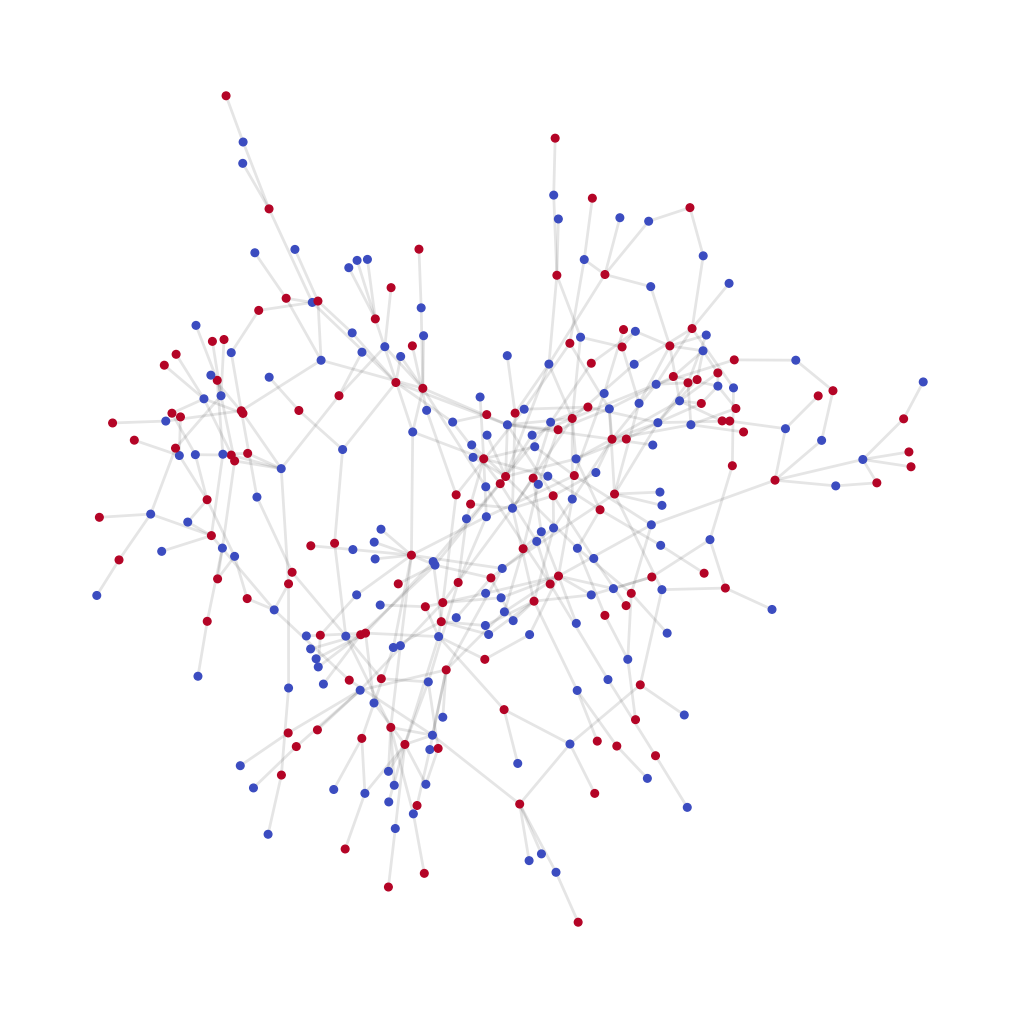

In [ ]:
graph_data = torch.load('playlist_data.pt')

In [ ]:
import pickle
with open("playlists_idx.dat","rb") as f:
    playlists_idx = pickle.load(f)

with open("tracks_idx.dat","rb") as f:
    tracks_idx = pickle.load(f)
n_playlists = len(playlists_idx)
n_tracks = len(tracks_idx)

### Try out some EDA

What does this graph look like? What are the number of nodes? What kind of information is available to you here? Do some EDA and get comfortable. This part won't be graded, but I doubt you will be able to progress much without understanding your data

## Section 1 - Data Preprocessing (Graded Sections start here)

Split the data into train-test-split sets.

In [ ]:
train_split, val_split, test_split = None,None,None

The dataset has data in `float32` format, but training will require you to use it in `torch.int64` (Just trust me bro.)
Just a reminder - 
1. Edge Index - Message Passing Edges
2. Edge Label Index - Supervision Edges

And if you don't understand what I'm saying, you should go back and see some lectures on link prediction

In [ ]:
#######################################################################
# Convert the edge_indexes and edge_label_indexes to integer type data.
# Some code here #
#######################################################################

In [ ]:
print(f"Train set has {train_split.edge_label_index.shape[1]} positives supervision edges")
print(f"Validation set has {val_split.edge_label_index.shape[1]} positive supervision edges")
print(f"Test set has {test_split.edge_label_index.shape[1]} positive supervision edges")

print(f"Train set has {train_split.edge_index.shape[1]} message passing edges")
print(f"Validation set has {val_split.edge_index.shape[1]} message passing edges")
print(f"Test set has {test_split.edge_index.shape[1]} message passing edges")

### The BPR Loss

You'll need a new kind of Loss function for this task, so here's a class for implementing BPR, Bayesian Personalised Ranking Loss. We've implemented this for you. You can change function names and stuff, however you are forbidden from changing the mathematical formula -

\begin{equation*}
    \text{BPR Loss}(i) = \frac{1}{|\mathcal{E}(i)|} \underset{{(i, j_{+}) \in \mathcal{E}(i)}}{\sum} \log \sigma \left( \text{score}(i, j_+) - \text{score}(i, j_-) \right)
\end{equation*}

In [ ]:
class BPRLoss(_Loss):
    r"""The Bayesian Personalized Ranking (BPR) loss.

    The BPR loss is a pairwise loss that encourages the prediction of an
    observed entry to be higher than its unobserved counterparts
    (see `here <https://arxiv.org/abs/2002.02126>`__).

    .. math::
        L_{\text{BPR}} = - \sum_{u=1}^{M} \sum_{i \in \mathcal{N}_u}
        \sum_{j \not\in \mathcal{N}_u} \ln \sigma(\hat{y}_{ui} - \hat{y}_{uj})
        + \lambda \vert\vert \textbf{x}^{(0)} \vert\vert^2

    where :math:`lambda` controls the :math:`L_2` regularization strength.
    We compute the mean BPR loss for simplicity.

    Args:
        lambda_reg (float, optional): The :math:`L_2` regularization strength
            (default: 0).
        **kwargs (optional): Additional arguments of the underlying
            :class:`torch.nn.modules.loss._Loss` class.
    """
    __constants__ = ['lambda_reg']
    lambda_reg: float

    def __init__(self, lambda_reg: float = 0, **kwargs):
        super().__init__(None, None, "sum", **kwargs)
        self.lambda_reg = lambda_reg

    def forward(self, positives: Tensor, negatives: Tensor,
                parameters: Tensor = None) -> Tensor:
        r"""Compute the mean Bayesian Personalized Ranking (BPR) loss.

        .. note::

            The i-th entry in the :obj:`positives` vector and i-th entry
            in the :obj:`negatives` entry should correspond to the same
            entity (*.e.g*, user), as the BPR is a personalized ranking loss.

        Args:
            positives (Tensor): The vector of positive-pair rankings.
            negatives (Tensor): The vector of negative-pair rankings.
            parameters (Tensor, optional): The tensor of parameters which
                should be used for :math:`L_2` regularization
                (default: :obj:`None`).
        """
        n_pairs = positives.size(0)
        log_prob = F.logsigmoid(positives - negatives).sum()
        regularization = 0

        if self.lambda_reg != 0:
            regularization = self.lambda_reg * parameters.norm(p=2).pow(2) 

        return (-log_prob + regularization) / n_pairs

### The GCN class
As mentioned, the primary model type we need here is a GCN. Use this boilerplate code to define your GCN class. This is merely a template, you can change it up if you think something else would be more intuitive. Some of the functions are defined to make this a little easier

As for the type of layer you need to use - It's the [LGConv](https://arxiv.org/abs/2002.02126) layer. PyG already offers this type of layer. [see here](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.LGConv.html#torch_geometric.nn.conv.LGConv).

There's other types of layers available, and this boilerplate code here should make it pretty easy to call upon many different PyG layers. This however is not necessary to have a successful model or for your score.

In [ ]:
class GCN(torch.nn.Module):
    """
      Here we adapt the LightGCN model from Torch Geometric for our purposes.
      We'll be using the LGCN  

    """

    def __init__(
        self,
        num_nodes: int,
        embedding_dim: int,
        num_layers: int,
        alpha: Optional[Union[float, Tensor]] = None,
        alpha_learnable = False,
        conv_layer = "LGC",
        name = None,
        **kwargs,
    ):
        super().__init__()
        alpha_string = "alpha" if alpha_learnable else ""
        self.name = f"LGCN_{conv_layer}_{num_layers}_e{embedding_dim}_nodes{num_nodes}_{alpha_string}"
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        if alpha_learnable == True:
          alpha_vals = torch.rand(num_layers+1)
          alpha = nn.Parameter(alpha_vals/torch.sum(alpha_vals))
          print(f"Alpha learnable, initialized to: {alpha.softmax(dim=-1)}")
        else:
          if alpha is None:
              alpha = 1. / (num_layers + 1)

          if isinstance(alpha, Tensor):
              assert alpha.size(0) == num_layers + 1
          else:
              alpha = torch.tensor([alpha] * (num_layers + 1))

        self.register_buffer('alpha', alpha)

        self.embedding = Embedding(num_nodes, embedding_dim)

        # initialize convolutional layers 
        self.conv_layer = conv_layer
        if conv_layer == "LGC":  
          self.convs = ModuleList([LGConv(**kwargs) for _ in range(num_layers)])

        self.reset_parameters()

    def reset_parameters(self):
        # Reset the parameters of all your layers
        pass
        

    def get_embedding(self, edge_index: Adj) -> Tensor:
        # Self explanatory
        return None

    def initialize_embeddings(self, data):
        # initialize with the data node features
        pass


    def forward(self, edge_index: Adj,
                edge_label_index: OptTensor = None) -> Tensor:
        # Implement the forward pass
        return None

    def predict_link(self, edge_index: Adj, edge_label_index: OptTensor = None,
                     prob: bool = False) -> Tensor:
        # Make a prediction. I hope you remember we want to deal with integers not floats 
        return None
    
    def predict_link_embedding(self, embed: Adj, edge_label_index: Adj) -> Tensor: 
        return None


    def recommend(self, edge_index: Adj, src_index: OptTensor = None,
                  dst_index: OptTensor = None, k: int = 1) -> Tensor:
        # This is what you'll use for inference
        return None


    def link_pred_loss(self, pred: Tensor, edge_label: Tensor,
                       **kwargs) -> Tensor:
        loss_fn = torch.nn.BCEWithLogitsLoss(**kwargs)
        return loss_fn(pred, edge_label.to(pred.dtype))


    def recommendation_loss(self, pos_edge_rank: Tensor, neg_edge_rank: Tensor,
                            lambda_reg: float = 1e-4, **kwargs) -> Tensor:
        r"""Computes the model loss for a ranking objective via the Bayesian
        Personalized Ranking (BPR) loss."""
        # The BPRLoss is defined for you in the next cell.
        loss_fn = BPRLoss(lambda_reg, **kwargs)
        return loss_fn(pos_edge_rank, neg_edge_rank, self.embedding.weight)
    
    def bpr_loss(self, pos_scores, neg_scores):
      return - torch.log(torch.sigmoid(pos_scores - neg_scores)).mean()

    def __repr__(self) -> str:
        # Used to get a summary of your model features
        return (f'{self.__class__.__name__}({self.num_nodes}, '
                f'{self.embedding_dim}, num_layers={self.num_layers})')


### Negative Sampling

If you only trained the model to minimise loss however, your model would perform pretty poorly. Why so? Assign every node the same embedding, and you would technically be minimizing the loss. The solution to that usually involves negative sampling, paying attention to the nodes that do not have an edge between them and hence must not be similar. 
Here are some negative sampling approaches for you to try out. We've done the first one, you do the rest (yes this is graded)- 
1. Random, no positive check: for each positive edge coming from a playlist $p_i$, randomly draw a track $t_j$ from the full set of track nodes such that ($p_i$, $t_j$) is the negative edge. For computational efficiency, we don't check if ($p_i$, $t_j$) is actually a negative edge, though probabilistically it is very likely.
2. Random, positive check: for each positive edge coming from a playlist $p_i$, randomly draw a track $t_j$ from the full set of track nodes such that ($p_i$, $t_j$) is the negative edge. We ensure that ($p_i$, $t_j$) is not a positive edge. 
3. Hard: for each positive edge coming from a playlist $p_i$, randomly draw a track $t_j$ from the top $k$ proportion of tracks, ranked by dot product similarity to $p_i$. For epoch 0, $k = 1$ and we lower it at each subsequent iteration. 

In [ ]:
def sample_negative_edges_nocheck(data, num_playlists, num_tracks, device = None):
  # note computationally inefficient to check that these are indeed negative edges
  playlists = data.edge_label_index[0, :]
  tracks = torch.randint(num_playlists, num_playlists + num_tracks - 1, size = data.edge_label_index[1, :].size())

  if playlists.get_device() != -1: # on gpu 
    tracks = tracks.to(device)

  neg_edge_index = torch.stack((playlists, tracks), dim = 0)
  neg_edge_label = torch.zeros(neg_edge_index.shape[1])

  if neg_edge_index.get_device() != -1: # on gpu 
    neg_edge_label = neg_edge_label.to(device)
    
  return neg_edge_index, neg_edge_label

def sample_negative_edges(data, num_playlists, num_tracks, device=None):
    neg_edge_index = None
    neg_edge_label = None
    return neg_edge_index, neg_edge_label

def sample_hard_negative_edges(data, model, num_playlists, num_tracks, device=None, batch_size=500, frac_sample = 1):
    neg_edges = None
    neg_edge_label = None

    return neg_edges, neg_edge_label

### Recall@K

Using only a loss seems like a bad idea however. Most of the time it can be quite hard to interpret loss alone. So let's just also keep an eye on the Recall@K, a popular one for RecSys.
For a playlist $i$, $P^k_i$ represents the set of the top $k$ predicted tracks for $i$ and $T_i$ the ground truth of connected tracks to playlist $i$, then we calculate 
$$
\text{recall}^k_i = \frac{| P^k_i \cap T_i | }{|T_i|}.
$$
If $T_i = 0$, then we assign this value to 1 (We don't really want to run into ZeroDivisionError). Note, if $T_i \subset P_i^k$, then the recall is equal to 1. Hence, our choice of $k$ matters a lot. 

You'll probably want to try out multiple values of k but maybe you can start in the ballpark of 2-3% of the total tracks

Note: When you evaluate this metric on the val or test set, make sure to filter the message passing edges from consideration, as the model can directly observe these.

I'm implementing this for you as a freebie :)

In [ ]:
def recall_at_k(data, model, k = 10000, batch_size = 64, device = None):
    with torch.no_grad():
        embeddings = model.get_embedding(data.edge_index)
        playlists_embeddings = embeddings[:n_playlists]
        tracks_embeddings = embeddings[n_playlists:]

    hits_list = []
    relevant_counts_list = []

    for batch_start in range(0, n_playlists, batch_size):
        batch_end = min(batch_start + batch_size, n_playlists)
        batch_playlists_embeddings = playlists_embeddings[batch_start:batch_end]

        # Calculate scores for all possible item pairs
        scores = torch.matmul(batch_playlists_embeddings, tracks_embeddings.t())

        # Set the scores of message passing edges to negative infinity
        mp_indices = ((data.edge_index[0] >= batch_start) & (data.edge_index[0] < batch_end)).nonzero(as_tuple=True)[0]
        scores[data.edge_index[0, mp_indices] - batch_start, data.edge_index[1, mp_indices] - n_playlists] = -float("inf")

        # Find the top k highest scoring items for each playlist in the batch
        _, top_k_indices = torch.topk(scores, k, dim=1)

        # Ground truth supervision edges
        ground_truth_edges = data.edge_label_index

        # Create a mask to indicate if the top k items are in the ground truth supervision edges
        mask = torch.zeros(scores.shape, device=device, dtype=torch.bool)
        gt_indices = ((ground_truth_edges[0] >= batch_start) & (ground_truth_edges[0] < batch_end)).nonzero(as_tuple=True)[0]
        mask[ground_truth_edges[0, gt_indices] - batch_start, ground_truth_edges[1, gt_indices] - n_playlists] = True

        # Check how many of the top k items are in the ground truth supervision edges
        hits = mask.gather(1, top_k_indices).sum(dim=1)
        hits_list.append(hits)

        # Calculate the total number of relevant items for each playlist in the batch
        relevant_counts = torch.bincount(ground_truth_edges[0, gt_indices] - batch_start, minlength=batch_end - batch_start)
        relevant_counts_list.append(relevant_counts)

    # Compute recall@k
    hits_tensor = torch.cat(hits_list, dim=0)
    relevant_counts_tensor = torch.cat(relevant_counts_list, dim=0)
    # Handle division by zero case
    recall_at_k = torch.where(
        relevant_counts_tensor != 0,
        hits_tensor.true_divide(relevant_counts_tensor),
        torch.ones_like(hits_tensor)
    )
    # take average
    recall_at_k = torch.mean(recall_at_k)

    if recall_at_k.numel() == 1:
        return recall_at_k.item()
    else:
        raise ValueError("recall_at_k contains more than one item.")

### ROC AUC Score

Finally, let's calculate the ROC AUC score for the binary predictions, which provides a measure of the efficiency of our model at distinguishing `true' track-playlist edges from non-existing ones. The higher this score, the better (a perfect score is achieved when ROC AUC = 1). This is done for you here - 

In [ ]:
def metrics(labels, preds):
  roc = roc_auc_score(labels.flatten().cpu().numpy(), preds.flatten().data.cpu().numpy())
  return roc 

## Section 2 Training and Testing

Finally. It's time to write your train and test functions for training and evaluation.

In [ ]:
# Train
def train(datasets, model, optimizer, loss_fn, args, neg_samp = "random"):
  print(f"Beginning training for {model.name}")

  train_data = None
  val_data = None

  stats = {
      'train': {
        'loss': [],
        'roc' : []
      },
      'val': {
        'loss': [],
        'recall': [], 
        'roc' : []
      }

  }
  val_neg_edge, val_neg_label = None, None
  for epoch in range(args["epochs"]): # loop over each epoch
    # Is your model ready?
    model.train()
    optimizer.zero_grad()
    
    # Negative sample the data - different methods may need different code
    neg_edge_index, neg_edge_label = None,None


    # calculate embedding
    embed = None
    # calculate pos, negative scores using embedding
    pos_scores = None
    neg_scores = None

    # concatenate pos, neg scores together and evaluate loss 
    scores = None
    labels = None

    # calculate loss function 
    if loss_fn == "BCE": 
      loss = None
    elif loss_fn == "BPR":
      loss = None
    
    train_roc = metrics(labels, scores)

    # Learn from your mistakes
    loss.backward()
    optimizer.step()

    # Test on the validation set
    val_loss, val_roc, val_neg_edge, val_neg_label = test(None)

    # I mean it'd be useless if you didn't even save the results
    stats['train']['loss'].append(loss)
    stats['train']['roc'].append(train_roc)
    stats['val']['loss'].append(val_loss)
    stats['val']['roc'].append(val_roc)

    print(f"Epoch {epoch}; Train loss {loss}; Val loss {val_loss}; Train ROC {train_roc}; Val ROC {val_roc}")

    if epoch % 10 == 0: 
      # calculate recall @ K - !ADJUST K!
      val_recall = recall_at_k(val_data, model, k = 10000, device = args["device"])
      print(f"Val recall {val_recall}")
      stats['val']['recall'].append(val_recall)

  pickle.dump(stats, open(f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pkl", "wb"))
  return stats

def test(model, data, loss_fn, neg_samp, epoch = 0, neg_edge_index = None, neg_edge_label = None):
  
  # I mean pretty similar now
  # Is your model ready to evaluate?

  with torch.no_grad(): # want to save RAM 

    # conduct negative sampling - different modes may need different code too
    if neg_samp == "random":
      neg_edge_index, neg_edge_label = None,None
    # obtain model embedding
    embed = None
    # calculate pos, neg scores using embedding 
    pos_scores = None
    neg_scores = None
    # concatenate pos, neg scores together and evaluate loss 
    scores = None
    labels = None
    # calculate loss - BCE was the default loss, while BPR is the new loss
    if loss_fn == "BCE": 
      loss = None
    elif loss_fn == "BPR":
      loss = None

    roc = metrics(labels, scores)
    
  return loss, roc, neg_edge_index, neg_edge_label

### Arguments

Maybe put your splits in a dict for easy access?

In [ ]:
datasets = {
    'train':train_split, 
    'val':val_split, 
    'test': test_split 
}

In [ ]:
training_args = {
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',  # For the love of God, please do use a GPU though.
    'num_layers' :  435345532551348923748,                      # Do you think this is a good choice?
    'emb_size' : 64,
    'weight_decay': 1e-5,
    'lr': 0.01,
    'epochs': 301
}

### Model Initialisation
Initialise your model with the parameters and nodes and whatever.

The Adam optimizer should work just fine for the task, so initialise that well as well.

In [ ]:
# initialize model and and optimizer 
num_nodes = n_playlists + n_tracks
model = GCN(None)
optimizer = None

It's time to put this data on a GPU.

In [ ]:
playlists_idx = torch.Tensor(playlists_idx).type(torch.int64).to(training_args["device"])
tracks_idx =torch.Tensor(tracks_idx).type(torch.int64).to(training_args["device"])
datasets['train'].to(training_args['device'])
datasets['val'].to(training_args['device'])
datasets['test'].to(training_args['device'])
model.to(training_args["device"])

The below code defines the directory to store the epoch-wise stats of your model

In [ ]:
# create directory to save model_stats
MODEL_STATS_DIR = "model_stats"
if not os.path.exists(MODEL_STATS_DIR):
  os.makedirs(MODEL_STATS_DIR)

### Call train()

In [ ]:
train(datasets, model, optimizer, "BPR", training_args, neg_samp = "random")

### Call test()

In [ ]:
test(model, datasets['test'], "BPR", neg_samp = "random")

### Pipeline Simplification

Instead of having to call everything one by one, let's package this training process into a pipeline

In [ ]:
def init_model(conv_layer, args, alpha = False):
  num_nodes = n_playlists + n_tracks
  model = GCN(None)
  model.to(args["device"])
  optimizer = None
  return model, optimizer 

In [ ]:
## For example:

# using BPR loss
loss_fn = "BPR"

# using hard sampling
neg_samp = "hard"

# Num epochs, layers, etc.
training_args['epochs'] = 301
training_args['num_layers'] = 4
model, optimizer = init_model("LGC", training_args)
lgc_stats_hard = train(datasets, model, optimizer, loss_fn, training_args, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

### Tuning

Use the simplified pipeline to train a couple of combinations of the model - changing the following variables (Do atleast 3 of each)

1. Negative Sampling Method (You should have 3 of them)
2. Number of Layers (<10 always)
3. Number of Epochs (vary by 100 atleast)

Be sure to save the results into different files. We'll use them in the next section to visualise better

In [ ]:
# If you had to stop for whatever reason, you can always reload the stats here! (just uncomment and change to correct paths)
# lgc_stats = pickle.load(open(f"{MODEL_STATS_DIR}/LGCN_LGC_4_e64_nodes34810__BPR_random.pkl", "rb"))
# lgc_stats_hard = pickle.load(open(f"{MODEL_STATS_DIR}/LGCN_LGC_4_e64_nodes34810__BPR_hard.pkl", "rb"))

## Section 3 - Training Visualisation
Phew. The hard part is done. But let's visualise this data better.

Write up code to plot the training and validation losses over epochs

In [ ]:
def plot_train_val_loss(stats_dict):
    # plt.show()
    return None

Now pass each of the different stats dict and plot the graphs - label them accordingly.

Plot a single graph to show the different Loss/Epoch graphs between the 3 different types of negative sampling methods

Plot a single graph to show Recall@K/Epoch for the 3 different types of negative sampling methods

Do the same thing for number of layers - both BPR Loss and Recall@K

What can you conclude about the hyperparameters for the best possible model?

\<Answer Here\>

# Section 4 - (Bonus) Embedding Visualisation

- This section is for bonus points. We'll use a manifold projection technique to visualise the embeddings. (You could also use other methods like PCA for example)

- The way this works is that we use dimensionality reduction to capture the most useful things the model learns in just 3 dimensions.

- UMAP is a library that will help you with this. You will pass in your high-dimensional embeddings to a function you can find from[UMAP Docs](https://umap-learn.readthedocs.io/en/latest/) and it will return 3-dimensional embeddings.

- We'll plot the embedding states of your model as it trains, every 10 epochs. This was the use of saving the states every 10 epochs in your training and testing code. This utilises the animation submodule of matplotlib, `matplotlib.animation`



In [ ]:
# Imports specifc to visualizations
import matplotlib.animation as animation
import umap
from IPython import display
from math import floor, ceil

### Dimensionality Reduction using UMAP

In [ ]:
# Reduce 64-dim embeddings to 3-dim using umap
umap_embs = [] # dimensionally reduced embeddings
epoch_str = [] # what epoch produced the embeddings

# Directory contianing the selected model embeddings
model_dir = "model_path/your_directory_name"

for filename in tqdm(sorted(os.listdir(join(os.getcwd(), model_dir)),
                       key=lambda name: int(name[:-3].split('_')[-1]))):
  embs = torch.load(join(os.getcwd(), model_dir, filename), map_location=torch.device('cpu')).detach().cpu().numpy()
  embs = embs[:n_playlists]
  u = None # Do Something
  umap_embs.append(u)
  epoch_str.append(filename[:-3].split('_')[-1])

### Prep to Plot
Now we need to pass these to our plotting library, which needs the dimensions separately. 

`extract_dim(dim)` will return the values for a single dimension `dim`

`compute_min_max(dim,h)` should return the limits of the values on a dimension. Automatic detection by matplotlib may lead to poorly scaled graphs.

In [ ]:
# Separate the embeddings dimensions for plotting
n = len(umap_embs)
n_emb = len(umap_embs[0])

def extract_dim(dim):
  """Given a dim index, return just that dim of umap_embs"""
  return [None]

x = extract_dim(0)
y = extract_dim(1)
z = extract_dim(2)

def compute_min_max(dim):
  """Given a dim index, compute dim limits"""
  return None,None

### Time to plot

Complete this function that will plot and update the visualisation of the embeddings over time

In [ ]:
def plot_embeddings(select_idx=None, color=None):
  """
  Plot the playlist embeddings.
  Optional parameters: select_idx, color are the selected
  indices to plot and the associated color mappings
  """
  # Indecies of embeddings - There are other ways to do it
  idx = [None]
  
  # Set up plot
  fig = plt.figure(figsize = (10, 10))
  subplt = plt.axes(projection ="3d")

  # Initialize the scatter plot
  my_sct = subplt.scatter(x[idx[0]], y[idx[0]], z[idx[0]],
                          alpha = 0.8, marker ='o')
  # Set axis limit
  subplt.set_xlim(compute_min_max(x))
  subplt.set_xlabel('x')
  subplt.set_ylim(compute_min_max(y))
  subplt.set_xlabel('y')
  subplt.set_zlim(compute_min_max(z))
  subplt.set_xlabel('z')

  # Define animation update funcion
  def update(itr, xa, ya, za, t):
    i = idx[itr]
    subplt.set_title('Embedding Epoch: ' + epoch_str[i])
    xyz = None
    my_sct._offsets3d = xyz
    return my_sct

  # Create animation
  ani = animation.FuncAnimation(fig, update,
                                fargs=(x, y, z),
                                interval=500,
                                save_count=len(idx))
  video = ani.to_html5_video()
  html = display.HTML(video)
  display.display(html)
  plt.close()

# End

And that's it! You could go one step further by poking around this data and plotting artists in different colours, to see if the embeddings are separating out artists whose styles don't match. We aren't grading you for that however. 

Hopefully you had some fun with this exercise. You could try running your model on newer Spotify data and seeing what happens. Maybe if you built an inference function you could also test it on your own playlists. 

Traditional ML architechture struggles to handle these kinds of tasks, as the data is related in a graphical structure and the data itself is a complex sequence which would be hard to analyse to generate embeddings for this use case. The upcoming topics will see us build even more on this idea, scaling your models for far larger datasets, poking around the internals of a GNN Model and the power of message passing.

***
***